<a href="https://www.kaggle.com/code/miltiadesgeneral/resnetmodel?scriptVersionId=117878753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -qU wandb
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu116

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


## Import Libraries
* Will use pytorch to build and run our model
* Use pandas to aggregate our data

In [2]:
import torch.nn as nn
import torch
from torch import Tensor
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.io import ImageReadMode
from torch.utils.data import DataLoader, Dataset, random_split

import tensorflow as tf

from typing import Type
# from torchvision.models import resnet18

import pydicom as dicom
from PIL import Image
import imageio

import numpy as np 
import pandas as pd
from pathlib import Path
import os
import math

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from joblib import Parallel, delayed

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
class CFG:
    # file paths
    train_data = "/kaggle/input/rsna-breast-cancer-detection/train.csv"
    test_data = "/kaggle/input/rsna-breast-cancer-detection/test.csv"
    train_images = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512"
    test_images = "/kaggle/input/rsna-breast-cancer-detection/test_images/10008"
    
    # wandb
    project= user_secrets.get_secret("PROJECT")
    entity= user_secrets.get_secret("ENTITY")
    
    # Device config
    device = "GPU"
    
    # image 
    image_size = 256
    
    # batching 
    batch_size = 64
    
    random_seed = 123
    num_workers = 2
    random = True
    
    # loss, optimizer, epochs
    loss_fn = nn.CrossEntropyLoss()
    epochs = 10
    
    

## Device Configuration

In [4]:
if CFG.device == "GPU":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    CFG.device = "cuda"
print(device)

cuda:0


## Initialize Weights and Biases

In [5]:
# import wandb
# try:
#     api_key = user_secrets.get_secret("WANDB")

#     wandb.login(key=api_key)
#     anonymous = None
# except:
#     anonymous = "must"
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')
# wandb.init(project=CFG.project, entity=CFG.entity)
# wandb.config = {
#   "learning_rate": 0.01,
#   "epochs": CFG.epochs,
#   "batch_size": CFG.batch_size
# }

## Import train data

In [6]:
TRAIN_DATA_PATH = CFG.train_data
TRAIN_IMG_PATH = CFG.train_images
TEST_DATA_PATH = CFG.test_data
TEST_IMAGE_PATH = CFG.test_images

train_df = pd.read_csv(f'{TRAIN_DATA_PATH}')
train_df['image_path'] = f'{TRAIN_IMG_PATH}'\
                    + '/' + train_df.patient_id.astype(str)\
                    + '/' + train_df.image_id.astype(str)\
                    + '.png'
print('Train:')
display(train_df.head(2))

Train:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...


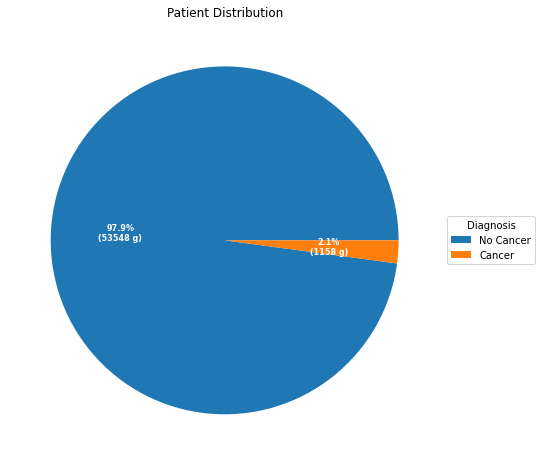

In [7]:
data = train_df["cancer"].value_counts().values
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
values = ["No Cancer", "Cancer"]
ax.legend(wedges, values,
          title="Diagnosis",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Patient Distribution")

plt.show()

The data is very asymmetrical with 97.9% of patients presenting negative and 2.1% of patients presenting positive.

In [8]:
from sklearn.utils import resample
cancer_df = train_df[train_df["cancer"] == 1]
clear_df = train_df[train_df["cancer"] == 0]

cancer_df = resample(cancer_df,
                    replace=True,
                    n_samples=len(clear_df),
                    random_state=123)
train_df = cancer_df.merge(clear_df, how="outer")

train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,1,8631,280870762,R,MLO,88.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,1,8631,280870762,R,MLO,88.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,1,8631,280870762,R,MLO,88.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,1,8631,280870762,R,MLO,88.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,1,8631,280870762,R,MLO,88.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-mammography-images-as-pngs/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107091,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-mammography-images-as-pngs/...
107092,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,/kaggle/input/rsna-mammography-images-as-pngs/...
107093,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,/kaggle/input/rsna-mammography-images-as-pngs/...
107094,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,/kaggle/input/rsna-mammography-images-as-pngs/...


In [9]:
train_df = train_df.sample(frac=0.5)
train_df = train_df.reset_index()

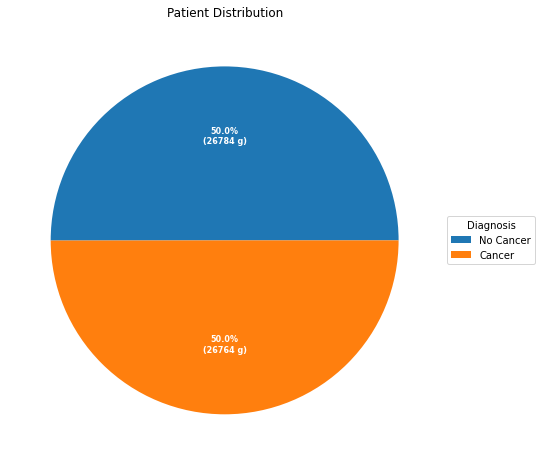

In [10]:
data = train_df["cancer"].value_counts().values
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
values = ["No Cancer", "Cancer"]
ax.legend(wedges, values,
          title="Diagnosis",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Patient Distribution")

plt.show()

## Data Pipeline

Split the train data into a train, val and test dataset
comprised of 80% train, 10% val, 10% test

In [11]:
# train test split for the train, val
from sklearn.model_selection import train_test_split
train_dataset, val_dataset = train_test_split(train_df, train_size=math.floor(0.80*(len(train_df))), random_state=CFG.random_seed)
val_dataset, test_dataset = train_test_split(val_dataset, train_size=math.floor(0.50*(len(val_dataset))), random_state=CFG.random_seed)

# reset index
train_dataset.reset_index(inplace=True)
val_dataset.reset_index(inplace=True)
test_dataset.reset_index(inplace=True)

# display the length
display(len(train_dataset))
display(len(val_dataset))
display(len(test_dataset))

42838

5355

5355

In [12]:
class buildDataset():
    def __init__(self, X, y, test=False):
        self.X = X
        self.y = y
        self.target_size = [CFG.image_size, CFG.image_size]
        self.test = test
        
    def __getitem__(self, index):
        """generates one sample of the data"""
        # Select sample
        target_size = self.target_size
        path = self.X[index]
        y = self.y[index]
        img = torchvision.io.read_image(path, mode = ImageReadMode.RGB)
        X = self.transform(img) if not self.test else self.test_transform(img)
        return X, y
    
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(CFG.image_size),
        T.RandomRotation(45),
        T.AutoAugment(),
        T.ToTensor()])
    
    test_transform = T.Compose([
        T.ToPILImage(),
        T.Resize(CFG.image_size),
        T.ToTensor()])

    def __len__(self):
        """denotes number of samples"""
        return len(self.X)

In [13]:
# Define the X, y values for the train and val datasets
X_train = train_dataset["image_path"]
y_train = train_dataset["cancer"]

X_val = val_dataset["image_path"]
y_val = val_dataset["cancer"]

In [14]:
# Construct the pytorch datasets for the train and val data
train_dataset = buildDataset(X_train, y_train)
val_dataset = buildDataset(X_val, y_val)

# Construct the pytorch dataloaders for the train and val data
train_dl = DataLoader(train_dataset, CFG.batch_size, shuffle=CFG.random, num_workers=CFG.num_workers, pin_memory=True)
val_dl = DataLoader(val_dataset, CFG.batch_size, shuffle=CFG.random, num_workers=CFG.num_workers, pin_memory=True)

In [15]:
def show_images(image, label, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(label)
    ax.imshow(make_grid((image.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, labels in dl:
        show_images(images, labels, nmax)
        break

In [16]:
for image, label in train_dl:
    print(len(label))
    print(len(image))
    break

64
64


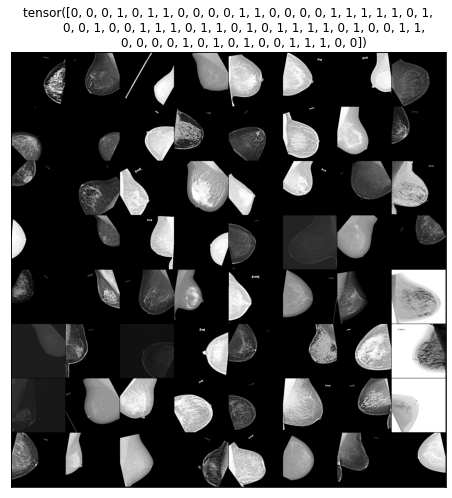

In [17]:
show_batch(train_dl)

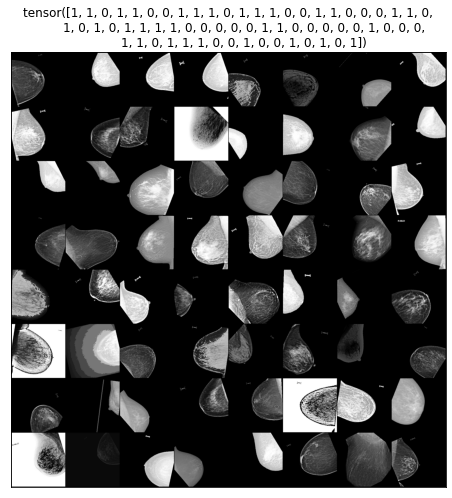

In [18]:
show_batch(val_dl)

## Pytorch Model

class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        
    def save(self, model_path):
        torch.save(self.state_dict(), model_path)


In [19]:
torch.cuda.empty_cache()

In [20]:
def build_model():
    # Create a ResNet-18 model
    model = torchvision.models.resnet18(pretrained=True)

    # Replace the last fully connected layer with a new layer for binary classification
    model.fc = nn.Linear(512, 2)

    model = model.to(device)
    return model

    
    

In [21]:
model = build_model()
#wandb magic
# wandb.watch(model, log_freq=100)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Training

In [22]:
class Train:
    def __init__(self):
        self = self
    # Training Function 
    def train(self):
        num_epochs = CFG.epochs
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

        
        best_accuracy = 0.0 

        print("Begin training...") 
        for epoch in range(1, num_epochs+1): 
            running_train_loss = 0.0 
            running_accuracy = 0.0 
            running_vall_loss = 0.0 
            total = 0 

            # Training Loop 
            for i, data in enumerate(train_dl, 0): 
            #for data in enumerate(train_loader, 0): 
                inputs, outputs = data  # get the input and real species as outputs; data is a list of [inputs, outputs]
                inputs = torch.as_tensor(inputs, device="cuda")
                outputs = torch.as_tensor(outputs, device="cuda")
                optimizer.zero_grad()   # zero the parameter gradients          
                predicted_outputs = model(inputs)   # predict output from the model 
                train_loss = CFG.loss_fn(predicted_outputs, outputs)   # calculate loss for the predicted output  
                train_loss.backward()   # backpropagate the loss 
                optimizer.step()        # adjust parameters based on the calculated gradients 
                running_train_loss +=train_loss.item()  # track the loss value 
                wandb.log({"loss": running_train_loss})
                if i % 100 == 99:    # print every 100 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_train_loss / 2000:.3f}')
                    running_loss = 0.0

            # Calculate training loss value 
            train_loss_value = running_train_loss/len(train_dl) 

            # Validation Loop 
            with torch.no_grad(): 
                model.eval() 
                for data in val_dl:
                    inputs, outputs = data
                    inputs = torch.as_tensor(inputs, device="cuda")
                    outputs = torch.as_tensor(outputs, device="cuda")
                    predicted_outputs = model(inputs) 
                    val_loss = CFG.loss_fn(predicted_outputs, outputs) 

                    # The label with the highest value will be our prediction 
                    _, predicted = torch.max(predicted_outputs, 1) 
                    running_vall_loss += val_loss.item()  
                    total += outputs.size(0) 
                    running_accuracy += (predicted == outputs).sum().item() 

            # Calculate validation loss value 
            val_loss_value = running_vall_loss/len(val_dl) 

            # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
            accuracy = (100 * running_accuracy / total)     

            # Save the model if the accuracy is the best 
            if accuracy > best_accuracy: 
                self.saveModel() 
                best_accuracy = accuracy 

            # Print the statistics of the epoch 
            print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))
    
    def saveModel(self): 
        path = "./ResNet18Model2.pth" 
        torch.save(model.state_dict(), path)
    

In [ ]:
class KFoldValidation:
    def __init__(self, model, dataset, epochs=10, criterion=CFG.criterion, optimizer=CFG.optimizer, device=CFG.device, path="./ResNet18Model3.pth"):
        self.model = model
        self.dataset = dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.path = path
        
    def train(self, train_loader):
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        for epoch in epochs:
            for data in train_loader:
                inputs, outputs = data  # get the input and real species as outputs; data is a list of [inputs, outputs]
                inputs = torch.as_tensor(inputs, device="cuda")
                outputs = torch.as_tensor(outputs, device="cuda")
                optimizer.zero_grad()   # zero the parameter gradients          
                predicted_outputs = self.model(inputs)   # predict output from the model 
                train_loss = CFG.loss_fn(predicted_outputs, outputs)   # calculate loss for the predicted output  
                train_loss.backward()   # backpropagate the loss 
                optimizer.step()        # adjust parameters based on the calculated gradients 
                running_train_loss += train_loss.item()  # track the loss value 

                wandb.log({"loss": running_train_loss}) # log on wandb
        return running_train_loss / len(train_loader) # return the loss
            
    def val(self, val_load):
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs = torch.as_tensor(inputs, device="cuda")
                    outputs = torch.as_tensor(outputs, device="cuda")
                    predicted_output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()
                    return val_loss / len(val_loader)
    
    def k_fold_cross_validation(self, k):
        dataset_size = len(self.dataset)
        fold_size = dataset_size // k
        train_losses, val_losses = [], []
        for i in range(k):
            print(f'Fold {i+1}/{k}')
            val_indices = list(range(i * fold_size, (i + 1) * fold_size))
            train_indices = list(set(range(dataset_size)) - set(val_indices))
            train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
            val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
            train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
            val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
            self.model.to(device)
            train_loss = train(model, train_loader, criterion, optimizer, device)
            val_loss = validate(model, val_loader, criterion, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            avg_train_loss = sum(train_losses) / k
            avg_val_loss = sum(val_losses) / k

            # Save the model if the accuracy is the best 
            if avg_val_loss > best_val_loss: 
                self.saveModel() 
                best_val_loss = avg_val_loss
        return avg_train_loss, avg_val_loss
    
    def saveModel(self):  
        torch.save(model.state_dict(), self.path)

In [23]:
# trainer = Train()
# trainer.train()
# print('Finished Training\n') 

# Testing

In [24]:
checkpoint_path = "/kaggle/input/resnet18model2/ResNet18Model2.pth"
checkpoint  = torch.load(checkpoint_path)
model.load_state_dict(checkpoint, strict=False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
X_test, y_test = test_dataset["image_path"], test_dataset["cancer"]
test_dataset = buildDataset(X_test, y_test)
test_dl = DataLoader(test_dataset, CFG.batch_size, shuffle=CFG.random, num_workers=CFG.num_workers, pin_memory=True)

In [26]:
class Test:
    def __init__(self, model, test_dl):
        self.model = model
        self.test_dl = test_dl
    def testAccuracy(self):
        test_dl = self.test_dl
        accuracy = 0.0
        total = 0.0

        with torch.no_grad():
            for data in test_dl:
                images, labels = data
                # run the model on the test set to predict labels
                images = torch.as_tensor(images, device="cuda")
                labels = torch.as_tensor(labels, device="cuda")
                outputs = self.model(images)
                # the label with the highest energy will be our prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()

        # compute the accuracy over all test images
        accuracy = (100 * accuracy / total)
        return(accuracy)
                
    # Function to show the images
    def imageshow(self, img):
        img = img.cpu()
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


    # Function to test the model with a batch of images and show the labels predictions
    def testBatch(self):
        classes = ["No Cancer", "Cancer"]
        batch_size = CFG.batch_size
        test_dl = self.test_dl
        # get batch of images from the test DataLoader  
        images, labels = next(iter(test_dl))
        images = torch.as_tensor(images, device="cuda")
        labels = torch.as_tensor(labels, device="cuda")

        # show all images as one image grid
        self.imageshow(torchvision.utils.make_grid(images))

        # Show the real labels on the screen 
        print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                                   for j in range(batch_size)))

        # Let's see what if the model identifiers the  labels of those example
        outputs = model(images)

        # We got the probability for every 10 labels. The highest (max) probability should be correct label
        _, predicted = torch.max(outputs, 1)

        # Let's show the predicted labels on the screen to compare with the real ones
        print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                                  for j in range(batch_size)))
    

In [27]:
tester = Test(model, test_dl)
tester.testAccuracy()

72.94117647058823

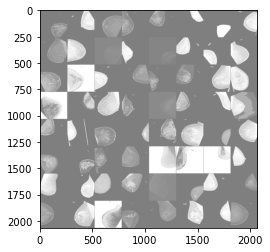

Real labels:  Cancer No Cancer No Cancer Cancer Cancer Cancer No Cancer Cancer No Cancer Cancer Cancer No Cancer No Cancer Cancer No Cancer Cancer Cancer Cancer Cancer Cancer Cancer No Cancer Cancer Cancer Cancer No Cancer No Cancer No Cancer Cancer Cancer No Cancer No Cancer Cancer No Cancer Cancer No Cancer Cancer No Cancer No Cancer No Cancer No Cancer Cancer Cancer No Cancer No Cancer Cancer No Cancer No Cancer No Cancer Cancer Cancer No Cancer No Cancer Cancer Cancer No Cancer No Cancer Cancer Cancer Cancer Cancer No Cancer No Cancer No Cancer
Predicted:  No Cancer No Cancer No Cancer Cancer Cancer Cancer No Cancer No Cancer No Cancer Cancer No Cancer No Cancer Cancer Cancer Cancer Cancer Cancer Cancer Cancer No Cancer Cancer Cancer Cancer Cancer Cancer No Cancer No Cancer No Cancer Cancer Cancer No Cancer No Cancer Cancer No Cancer Cancer No Cancer No Cancer No Cancer No Cancer No Cancer No Cancer No Cancer Cancer No Cancer No Cancer Cancer No Cancer No Cancer No Cancer No Cancer

In [28]:
tester = Test(model, test_dl)
tester.testBatch()

In [29]:
preds = torch.tensor([]).to(device="cuda")
target = torch.tensor([]).to(device="cuda")
for data in test_dl:
    images, labels = data
    # run the model on the test set to predict labels
    images = torch.as_tensor(images, device="cuda")
    labels = torch.as_tensor(labels, device="cuda")
    outputs = model(images)
    # the label with the highest energy will be our prediction
    _, predicted = torch.max(outputs.data, 1)
    preds = torch.cat((preds, predicted), 0)
    target = torch.cat((target, labels), 0)

In [30]:
from torchmetrics.classification import BinaryConfusionMatrix
metric = BinaryConfusionMatrix().to(device="cuda")
cfn_mtrx = metric(preds, target)

In [31]:
cfn_mtrx = pd.DataFrame(cfn_mtrx.cpu().numpy(), columns=["Positive", "Negative"])
cfn_mtrx

,Positive,Negative
0,1914,644
1,811,1986


In [32]:
df = pd.DataFrame()
df["predicted"] = preds.cpu().numpy()
df["target"] = target.cpu().numpy()
df["diff"] = abs(df["predicted"] - df["target"])

In [33]:
f"Model produces {(df['diff'].sum() / len(df)) * 100:.2f}% inaccurate results"

'Model produces 27.17% inaccurate results'